In [9]:
import json
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [10]:
nlp = spacy.load("en_core_web_trf")

In [11]:
def read_texts(path):
    data = json.load(open(path, "r", encoding="utf-8"))
    texts = []
    for i, item in enumerate(data):
        if isinstance(item, dict) and "text" in item:
            texts.append(str(item["text"]))
        elif isinstance(item, str):
            texts.append(item)
    return texts

texts = read_texts("texts.json")
print(len(texts))

106


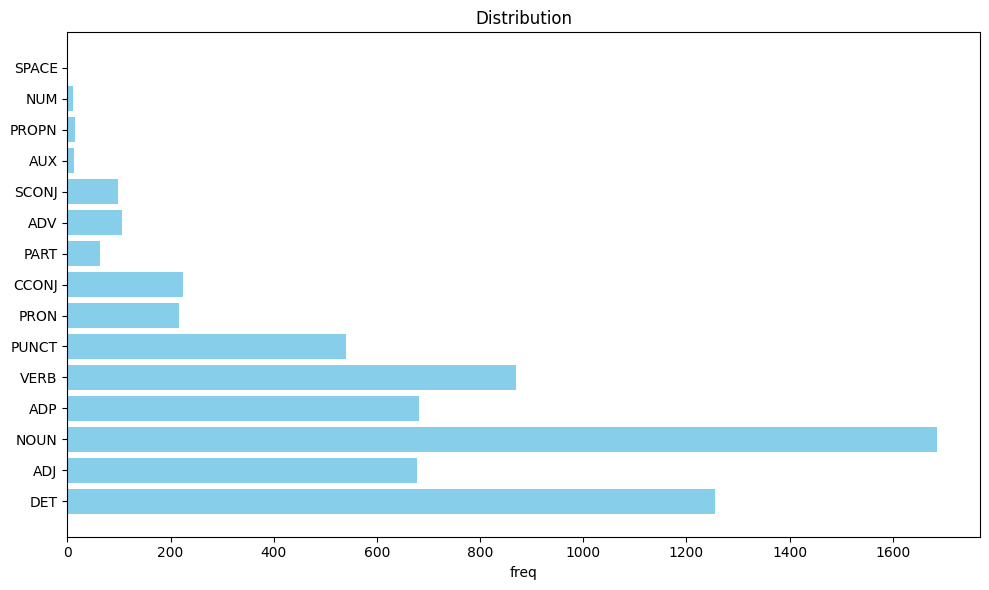

DET: 1256
ADJ: 677
NOUN: 1685
ADP: 681
VERB: 870
PUNCT: 540
PRON: 216
CCONJ: 224
PART: 63
ADV: 105
SCONJ: 98
AUX: 12
PROPN: 14
NUM: 10
SPACE: 2


In [12]:
pos_counts = Counter()

for text in texts:
    doc = nlp(text)
    for token in doc:
        pos_counts[token.pos_] += 1


pos_labels = list(pos_counts.keys())
pos_values = list(pos_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(pos_labels, pos_values, color='skyblue')
plt.xlabel('freq')
plt.title('Distribution')
plt.tight_layout()
plt.show()

for pos, count in pos_counts.items():
    print(f"{pos}: {count}")

In [13]:
with open("scene_graphs.json", "r") as f:
    scene_data = json.load(f)

total_objects = 0
total_attributes = 0
total_object_attributes = 0
total_frames = 0

for scene in scene_data:
    for frame in scene:
        total_frames += 1
        nodes = frame["nodes"]
        total_objects += len(nodes)
        
        for node in nodes:
            total_attributes += len(node["attributes"])
            total_object_attributes += len(node["attributes"])

average_objects_per_frame = total_objects / total_frames if total_frames != 0 else 0
average_attributes_per_frame = total_attributes / total_frames if total_frames != 0 else 0
average_attributes_per_object = total_object_attributes / total_objects if total_objects != 0 else 0

print(f"场景图中的平均对象个数：{average_objects_per_frame:.2f}")
print(f"场景图中的平均属性个数：{average_attributes_per_frame:.2f}")
print(f"每个对象的平均属性个数：{average_attributes_per_object:.2f}")

场景图中的平均对象个数：4.86
场景图中的平均属性个数：7.10
每个对象的平均属性个数：1.46


In [ ]:
def read_texts(path):
    data = json.load(open(path, "r", encoding="utf-8"))
    texts = []
    for item in data:
        if isinstance(item, dict) and "text" in item:
            texts.append(str(item["text"]))
        elif isinstance(item, str):
            texts.append(item)
    return texts

texts = read_texts("texts.json")
with open("scene_graphs.json", "r", encoding="utf-8") as f:
    scene_data = json.load(f)

N = min(len(texts), len(scene_data))
texts = texts[:N]
scene_data = scene_data[:N]
k_human = 5 if N >= 5 else N
labels = ["LLM"] * (N - k_human) + ["HUMAN"] * k_human

In [22]:
pos_counts = {"LLM": Counter(), "HUMAN": Counter()}
for i, text in enumerate(texts):
    grp = labels[i]
    doc = nlp(text)
    for tok in doc:
        pos_counts[grp][tok.pos_] += 1

all_pos = sorted(set(list(pos_counts["LLM"].keys()) + list(pos_counts["HUMAN"].keys())))
rows = []
for tag in all_pos:
    llm_c = pos_counts["LLM"][tag]
    hum_c = pos_counts["HUMAN"][tag]
    rows.append([tag, llm_c, hum_c])
pos_df = pd.DataFrame(rows, columns=["POS", "LLM_count", "HUMAN_count"])
pos_df["LLM"]   = pos_df["LLM_count"]   / pos_df["LLM_count"].sum()   if pos_df["LLM_count"].sum()   else 0
pos_df["HUMAN"] = pos_df["HUMAN_count"] / pos_df["HUMAN_count"].sum() if pos_df["HUMAN_count"].sum() else 0
pos_df["delta(HUMAN-LLM)"] = (pos_df["HUMAN"] - pos_df["LLM"])
pos_df = pos_df.sort_values("HUMAN_count", ascending=False)

<Figure size 1000x500 with 0 Axes>

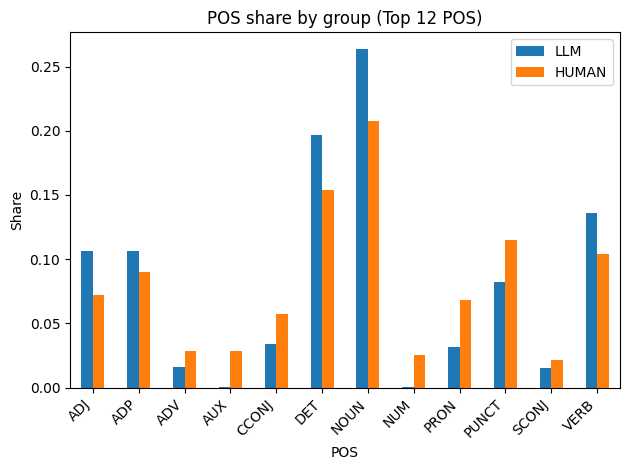

In [23]:
topK = 12
top_tags = pos_df.head(topK)["POS"].tolist()
plot_df = pos_df[pos_df["POS"].isin(top_tags)].set_index("POS")[["LLM", "HUMAN"]].sort_index()

plt.figure(figsize=(10, 5))
plot_df.plot(kind="bar")
plt.ylabel("Share")
plt.title("POS share by group (Top 12 POS)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

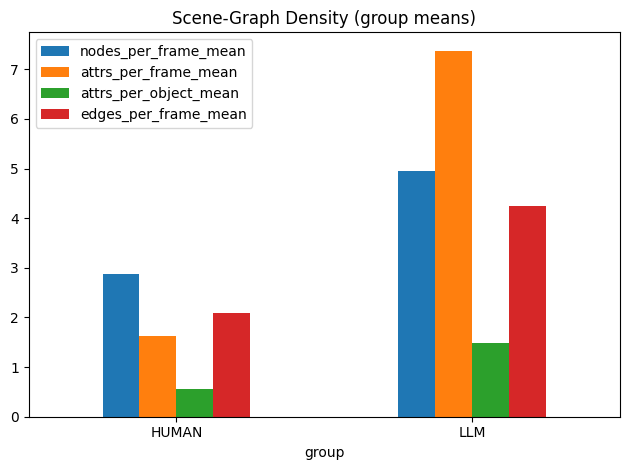

In [24]:
def story_metrics(frames):
    frames_count = len(frames) or 1
    nodes_total, attrs_total, edges_total, objects_total = 0, 0, 0, 0
    for fr in frames:
        nodes = fr.get("nodes", []) or []
        edges = fr.get("edges", []) or []
        nodes_total += len(nodes)
        edges_total += len(edges)
        for nd in nodes:
            attrs_total += len(nd.get("attributes", []) or [])
        objects_total += len(nodes)
    return {
        "frames": frames_count,
        "nodes_per_frame": nodes_total / frames_count,
        "attrs_per_frame": attrs_total / frames_count,
        "attrs_per_object": (attrs_total / objects_total) if objects_total else 0.0,
        "edges_per_frame": edges_total / frames_count,
    }

rows = []
for i, story in enumerate(scene_data):
    m = story_metrics(story)
    m["group"] = labels[i]
    rows.append(m)
sg_df = pd.DataFrame(rows)

agg = sg_df.groupby("group").agg(
    stories=("frames", "count"),
    frames_total=("frames", "sum"),
    frames_median=("frames", "median"),
    nodes_per_frame_mean=("nodes_per_frame", "mean"),
    attrs_per_frame_mean=("attrs_per_frame", "mean"),
    attrs_per_object_mean=("attrs_per_object", "mean"),
    edges_per_frame_mean=("edges_per_frame", "mean"),
).round(3)

metrics_to_plot = ["nodes_per_frame_mean", "attrs_per_frame_mean", "attrs_per_object_mean", "edges_per_frame_mean"]
plot2 = agg[metrics_to_plot]

plt.figure(figsize=(10, 5))
plot2.plot(kind="bar")
plt.title("Scene-Graph Density (group means)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()